---

# <div align="center">Q-Agent on tmpTask 
    
---

Defines the reinforcement learning Q-Learning Agent on the tmpTask and its learning paraments
* r = reward
* RPE = r - Q(s,a)
* 𝛼Gain = Learning Rate when RPE > 0
* 𝛼Loss = Learning Rate when RPE ≤ 0
* 𝜷 = Inverse Temperature (degree of randomness)
* 𝜸 = Reward strength (representative of dopamine reactivity) ------ did we use gamma in code?

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from __future__ import division
import numpy as np
from numpy import array
from numpy.random import sample as rs
from numpy import newaxis as na
import pandas as pd
from pandas import DataFrame
from scipy.stats import sem
import seaborn as sns
import string
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import csv
from __future__ import division
from future.utils import listvalues
from scipy.stats.stats import sem
#import ptitprince as pt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


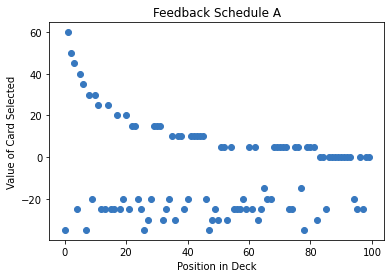

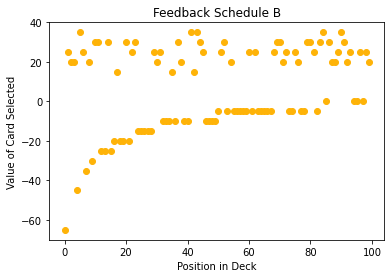

Text(0, 0.5, 'Value of Card Selected')

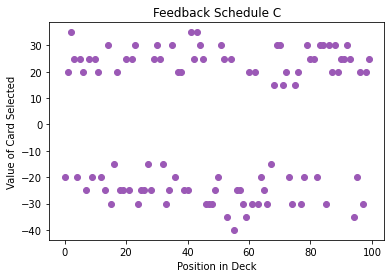

In [3]:
def buildDecks(base, sigma, numerator, logpart, scale, intercept, divide_index):
    wholeDeckA = []
    wholeDeckB = []
    wholeDeckC = []
    for i in range(1, 101):
        t = i-1
        err =  np.random.normal(0, 5)
        flip = np.random.binomial(1,.5)
        if flip == 0: #reward trial
          currCard = (numerator/(math.log((i+logpart), scale)))+intercept
          wholeDeckA.append(currCard)
          currCard = base + np.random.normal(0, sigma)
          wholeDeckB.append(currCard)
          currCard = base + np.random.normal(0, sigma)
          wholeDeckC.append(currCard)
        else: # punishment trial
          currCard = -1* base + np.random.normal(0, sigma)
          wholeDeckA.append(currCard)
          currCard = ((-1 * numerator)/(math.log((i+logpart), scale)))-intercept
          wholeDeckB.append(currCard)
          currCard = -1 * base + np.random.normal(0, sigma)
          wholeDeckC.append(currCard)
    wholeDeckA = [(5 * round(i/divide_index)) for i in wholeDeckA]
    wholeDeckB = [(5 * round(i/divide_index)) for i in wholeDeckB]
    wholeDeckC = [(5 * round(i/divide_index)) for i in wholeDeckC]
    return wholeDeckA, wholeDeckB, wholeDeckC
deckA, deckB, deckC = buildDecks(25, 5, 2000, 5, 1.1, -40, 5)

plt.show()
plt.scatter(range(len(deckA)), deckA, color = "#3778bf")
plt.title('Feedback Schedule A')
plt.xlabel("Position in Deck")
plt.ylabel("Value of Card Selected")

plt.show()
plt.scatter(range(len(deckB)), deckB, color = "#feb308")
plt.title('Feedback Schedule B')
plt.xlabel("Position in Deck")
plt.ylabel("Value of Card Selected")

plt.show()
plt.scatter(range(len(deckC)), deckC, color = "#9b59b6")
plt.title('Feedback Schedule C')
plt.xlabel("Position in Deck")
plt.ylabel("Value of Card Selected")

## Update Q (State, Action values)
#### Defines the function that first calculates and updates the Q values of the Q-agent

<div align="center"> If $r - Q(s, a) > 0:$
<div align="center"> $\alpha = \alpha_{Gain}$ 

<div align="center"> Else: 
<div align="center"> $\alpha = \alpha_{Loss}$  

$$Update(Q): Q(s,a) += \alpha(\gamma r + max(Q(s')) - Q(s,a))$$ 
 				
                
$$Update(Q): Q(s,a) += \alpha_{Loss}(\gamma p + max(Q(s')) - Q(s,a))$$ 

In [4]:
def update_Qi(Qval, reward, alpha, gamma):
    """ update q-value of selected action, given reward and alpha
    alpha is changed depending on RPE (reward prediction error)
    (whether (reward - Qval) >= 0, reward gains or (reward - Qval) < 0, reward loss)
    """
    return Qval + (alpha * ((gamma*reward) - Qval))

## P (Selection Probabilities)
#### Defines the function that updates the P values of the Q-Agent

$$Update(P)= \frac {e^{\beta Q_i}}{\sum e^{\beta * (Q_{vector} - max(Q_{vector}))}} $$


* "...where T is a positive parameter called the temperature. High temperatures cause the actions to be all (nearly) equiprobable. Low temperatures cause a greater difference in selection probability for actions that differ in their value estimates."

inverse temperature = beta = greediness
* As temperature increases, beta decreases & greediness DECREASES (explorative)
* As temperature decreases, beta increases & greediness INCREASES (exploitative)

In [5]:
def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """ 
    Zvector = Qvector - max(Qvector)
    denom = np.sum(np.exp(beta * Zvector))
        
    resulting_pdata = np.array([np.exp(beta*Q_i) / denom for Q_i in Zvector])
    
    return resulting_pdata

## tmpTask 
#### Defines the tmpTask played by the Q-Agent
#### tmpTAsk game design 
100 Trials total (from Bechara, 1997)

|  | Deck A | Deck B | Deck C | |
| -------- | --- | --- | --- | --- | --- |
| p(gains) | "negative" | "positive" | negligibly zero | |
| g(losses) | 0.5 | 0.1 | 0.5 |  |
| avg gains | \$100 | \$100 | \$50 | \$50 |
| avg losses | -\$250 | -\$1250 | -\$50 | -\$250 |
| overall gains | -\$75 | -\$75 | \$0 | \$20 |


#### Alternative designs
- switch overall gains of C & D so that C has positive gains and keeps p(gains)=0.5, 
	and D has $0 gains and keeps p(gains)=0.9
	- may be interesting to see the effect of alpha on frequency of gains

In [6]:
class tmpTask(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        preward (list): 1xN vector of reward probabilities for each of N bandits
        rvalues (list): 1xN vector of payout values for each of N bandits
    """    
            
    def __init__(self):
                
        self.all_cards = buildDecks(25, 5, 2000, 5, 1.1, -40, 5) 
        pd.read_csv('deckResults1.csv') #- original
        #print(self.all_cards)
        #self.deck_gains = self.all_cards.sum()
        
        #return self.all_cards
        all_cardsDF = pd.DataFrame()
        all_cardsDF['A'] = self.all_cards[0]
        all_cardsDF['B'] = self.all_cards[1]
        all_cardsDF['C'] = self.all_cards[2]
        self.all_cards = all_cardsDF
        #print(self.all_cards.head())
        
        #self.deck_counters = np.zeros(len(self.all_cards), dtype = tuple)
        
        self.deck_counters = np.zeros(len(self.all_cards.columns), dtype = int)
        #print(self.all_cards)
        #print(self.all_cards.columns)
        #print(self.deck_counters)


    def get_feedback(self, action_ix):
    
        if self.deck_counters[action_ix] == 49:
            self.deck_counters[action_ix] = 0
        
        else:    
            self.deck_counters[action_ix] += 1
        
        curr_counter = self.deck_counters[action_ix]
        
        feedback = self.all_cards.iloc[curr_counter, action_ix]
        
        return feedback
     

## Q-Agent
#### Defines the reinforcement learning Q-Learning Agent on the tmpTask and its learning paraments

* r = reward
* RPE = r - Q(s,a)
* 𝛼Gain = Learning Rate when RPE > 0
* 𝛼Loss = Learning Rate when RPE ≤ 0
* 𝜷 = Inverse Temperature (degree of randomness)
* 𝜸 = Reward strength (representative of dopamine reactivity)

In [7]:
class Qagent(object):

    """ defines the learning parameters of single q-learning agent
    in the High-Frequency Addictive Dopamine Reinforcement Task

    ::Arguments::
        alpha_g (float): learning rate for gains
        alpha_l (float): learning rate for losses
        beta (float): inverse temperature parameter
        gamma (float): sensitivity to reward or losses
        preward (list): 1xN vector of reward probaiblities for each of N decks
        rvalues (list): 1xN vector of payout values for each of N decks
                        IF rvalues is None, all values set to 1
        pvalues (list): 1xN vector of punishment values for each of N decks
                        IF rvalues is None, all values set to 1

    """
    

    def __init__(self, alpha_g,
                       alpha_l, 
                       beta, 
                       gamma, 
                       decks=['A', 'B', 'C']):
        if decks is None:
            decks = ['A', 'B', 'C']

        # calling tmpTask() function with arguments in Qagent() object
        self.tmpTask = tmpTask()
        
        self.alpha_data = []
        
        self.rpe_data = []
        
        
        # setting parameters passed through Qagent() as arguments
        self.set_params(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, gamma=gamma, decks=decks)
        


    def set_params(self, **kwargs):
        
        """ update parameters of q-learning agent:
                alpha_g = learning rate for gains
                alpha_l = learning rate for losses
                beta = inv. temperature,
                gamma = representative of dopamine release
                epsilon = exploration constant to randomize decisions
                preward = probability of reward, p(reward)
                rvalues = reward amounts  (+$)
                pvalues = punishment amounts (-$)
        """

        kw_keys = list(kwargs)

        if 'alpha_g' in kw_keys:
            self.alpha_g = kwargs['alpha_g']

        if 'alpha_l' in kw_keys:
            self.alpha_l = kwargs['alpha_l']

        if 'beta' in kw_keys:
            self.beta = kwargs['beta']

        if 'gamma' in kw_keys:
            self.gamma = kwargs['gamma']
        
        if 'decks' in kw_keys:
            self.decks = kwargs['decks']

        # number of choices/options
        self.nact = len(self.decks)

        # actions limited to number of choices/options
        self.actions = np.arange(self.nact)


    def play_tmpTask(self, ntrials=100, get_output=True):
        
        """ simulates agent performance on a multi-armed bandit task

        ::Arguments::
            ntrials (int): number of trials to play bandits
            get_output (bool): returns output DF if True (default)

        ::Returns::
            DataFrame (Ntrials x Nbandits) with trialwise Q and P
            values for each bandit
        """
        
        pdata = np.zeros((ntrials + 1, self.nact))
        
        pdata[0, :] = np.array([1/self.nact]*self.nact)
        
        qdata = np.zeros_like(pdata)
        self.choices = []
        self.feedback = []

        for t in range(ntrials):

            # select bandit arm (action)            
            act_i = np.random.choice(self.actions, p=pdata[t, :])
            
            # observe feedback
            r = self.tmpTask.get_feedback(act_i)

            # update value of selected action depending on whether it is a gain or loss
            rpe = r - qdata[t, act_i]
            if rpe >= 0:
                alpha = self.alpha_g
            if rpe < 0:
                alpha = self.alpha_l
            
            qdata[t+1, act_i] = update_Qi(qdata[t, act_i], r, alpha, self.gamma)

            # broadcast old q-values for unchosen actions
            for act_j in self.actions[np.where(self.actions!=act_i)]:
                qdata[t+1, act_j] = qdata[t, act_j]

            # update action selection probabilities and store data
            pdata[t+1, :] = update_Pall(qdata[t+1, :], self.beta)
            
            self.choices.append(act_i)
            self.feedback.append(r)
            self.rpe_data.append(rpe)
            self.alpha_data.append(alpha)
        
        self.pdata = pdata[1:, :]
        self.qdata = qdata[1:, :]
        self.make_output_df()

        if get_output:
            return self.data.copy()


    def make_output_df(self):
        """ generate output dataframe with trialwise Q and P measures for each bandit,
        as well as choice selection, and feedback
        """
        df = pd.concat([pd.DataFrame(dat) for dat in [self.qdata, self.pdata]], axis=1)
        columns = np.hstack(([['{}{}'.format(x, c) for c in self.actions] for x in ['q', 'p']]))
        df.columns = columns
        df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
        df['choice'] = self.choices
        df['feedback'] = self.feedback
        
        # replace 3 with self.tmpTask.deck_gains.values.argmax()
        df['optimal'] = np.where(df['choice']==1, 2, 0) 
        df['RPE'] = self.rpe_data
        df['alpha'] = self.alpha_data
        df.insert(0, 'agent', 1)
        self.data = df.copy()


    def simulate_multiple(self, nsims=10, ntrials=1000):
        """ simulates multiple identical agents on multi-armed bandit task
        """
        dflist = []
        for i in range(nsims):
            data_i = self.play_tmpTask(ntrials=ntrials, get_output=True)
            data_i['agent'] += i
            dflist.append(data_i)
        return pd.concat(dflist)

## Q-Agent Trial Analysis

In [8]:
def get_optimal_auc(df, nblocks=25, verbose=False, as_percent=True):
    xdf = blockify_trials(df, nblocks=nblocks)
    muOptDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    auc = pd.pivot_table(muOptDF, values='optimal', index='block').values.sum()
    if as_percent:
        auc = (auc / nblocks) * 100
        #print("Optimal Choice (Deck B) chosen {:.2f}% of time".format(auc))
    if verbose:
        #print("Optimal Choice (Deck B) chosen {:.2f} times".format(auc))

        return auc #got error when tried to return outside of function so moved in...

def analyze_bandits(df, nblocks=25, get_err=False): 
    xdf = blockify_trials(df, nblocks=nblocks)
    optDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    muOpt = pd.pivot_table(optDF, values='optimal', index='block').values
    muOpt = np.hstack(muOpt)
    if get_err:
        errOpt = pd.pivot_table(optDF, values='optimal', index='block', aggfunc=sem).values*1.96
        errOpt = np.hstack(errOpt)
    else:
        errOpt = np.zeros_like(muOpt)
    return muOpt, errOpt

def blockify_trials(data, nblocks=5, conds=None, groups=['agent']):

    datadf = data.copy()
    if conds is not None:
        if type(conds) is str:
            conds = [conds]
        groups = groups + conds

    idxdflist = []
    for dfinfo, idxdf in datadf.groupby(groups):
        ixblocks = np.array_split(idxdf.trial.values, nblocks)
        blocks = np.hstack([[i+1]*arr.size for i, arr in enumerate(ixblocks)])
        idxdf = idxdf.copy()
        colname = 'block'
        idxdf[colname] = blocks
        idxdflist.append(idxdf)

    return pd.concat(idxdflist)


## Q-Agent Trial tmpTask Scores Calculation 
* Payoff ***still using these terms??
* Sensitivity to Frequency of Rewards

In [9]:
#def __init__(self):
def get_tmpTask_scores(data):
    #all_of_cards = self.all_cards

    # initializing a choice dictionary with the default of 0 times chosen
    choice_dict = {0: 0, 1:0, 2:0}

    # updating the choice dictionary with the deck choices made
    choices_made = data['choice'].value_counts(sort = False).to_dict()

    for key, value in choices_made.items():
        choice_dict[key] = value
    A, B, C = choice_dict.get(0), choice_dict.get(1), choice_dict.get(2)

    # Payoff (P)
    probC =  C/100 #(C - (A + B)) #probability of selecting this deck during the whole game

    probB = B/100

    #sensitivity to early high reward 
    probA = A/100

    # Sensitivity to frequency of gains (Q)
    #sensitivityB = (B) - (A + C)
    #print(pd.Series((probA, probB, probC)))
    return pd.Series((probA, probB, probC))

## Q-Agent Trial Run Plots
* Choice Raster Plot
* Q(Decks) Line Plot
* P(Decks) Line Plot
* % Optimal Deck (B) Chosen Line Area Plot

In [10]:
def plot_qlearning(data, nblocks=25, analyze=True):

    if analyze:
        auc = get_optimal_auc(data, nblocks, as_percent=True)

    sns.set(style='white', font_scale=1.3)
    clrs = ['#3778bf', '#feb308', '#9b59b6', '#2ecc71', '#e74c3c',
            '#3498db', '#fd7f23', '#694098', '#319455', '#f266db',
            '#13579d', '#fa8d67'  '#a38ff1'  '#3caca4', '#c24f54']

    f, ([[ax0, ax1], [ax2, ax3]]) = plt.subplots(2, 2, figsize=(15,10))
    #ax0.tick_params(fontsize=20)
    #ax0.yticks(fontsize=20)
    '''
    ax1.xticks(fontsize=20)
    ax1.yticks(fontsize=20)
    
    ax2.xticks(fontsize=20)
    ax2.yticks(fontsize=20)
    
    ax3.xticks(fontsize=20)
    ax3.yticks(fontsize=20)
    
  '''  
    df = data.copy()
    nactions = int(df.columns[-6].split('p')[-1])+1
    actions = np.arange(nactions)

    mudf = df.groupby('trial').mean().reset_index()
    errdf = df.groupby('trial').sem().reset_index()*1.96
    x = mudf.trial.values
    

    plot_err = True
    if np.isnan(errdf.loc[1, 'q0']):
        plot_err = False

    x3 = np.arange(1, nblocks+1)
    chance = 1/nactions
    mu3, err3 = analyze_bandits(df, nblocks=nblocks, get_err=plot_err)
    ax3.plot(x3, mu3, color='k')
    ax3.hlines(chance, 1, x3[-1], color='k', linestyles='--', label='chance')
    

    

    for i, act in enumerate(actions):
        muQ = mudf['q{}'.format(act)].values
        muP = mudf['p{}'.format(act)].values

        choices = [data[data["choice"] == i]["trial"].values]
        ax0.eventplot(positions=choices, lineoffsets=[i+1], 
                      orientation='horizontal', color=clrs[i])
        letters = ["A", "B", "C"]
        ax1.plot(x, muQ, label='$deck_{}$'.format(letters[i]), color=clrs[i])
        ax2.plot(x, muP, color=clrs[i])

        
        
        if plot_err:
            errQ = errdf['q{}'.format(act)].values
            errP = errdf['p{}'.format(act)].values
            ax1.fill_between(x, muQ-errQ, muQ+errQ, color=clrs[i], alpha=.2)
            ax2.fill_between(x, muP-errP, muP+errP, color=clrs[i], alpha=.2)
            if i==0:
                ax3.fill_between(x3, mu3-err3, mu3+err3, color='k', alpha=.15)
        else:
            ychance = np.ones(mu3.size) * chance
            mu3A = np.copy(mu3)
            mu3B = np.copy(mu3)
            mu3A[np.where(mu3<=chance)] = chance
            mu3B[np.where(mu3>=chance)] = chance
            ax3.fill_between(x3, ychance, mu3A, color='#2ecc71', alpha=.15)
            ax3.fill_between(x3, ychance, mu3B, color='#e74c3c', alpha=.15)

    ax0.set_yticks([1,2,3], minor=False)
    ax0.set_yticklabels(["A", "B", "C"], fontdict=None, minor=False)
    ax0.set_ylabel('Deck Choices')

    
    #ax1.legend(bbox_to_anchor=(-1.5,0.3), loc="lower right")
    ax1.set_ylabel('$Q(Deck)$')
    ax1.set_title('Value')

    ax2.set_ylabel('$P(Deck)$')
    ax2.set_ylim(0,1)
    ax2.set_title('Softmax Prob.')

    ax3.set_ylim(0,1)
    ax3.set_ylabel('% Optimal Deck B') #was C maybe try changing to B?
    ax3.set_xticks([1, nblocks+1])
    ax3.set_xticklabels([1, df.trial.max()])
    ax3.legend(loc="upper right")

    for ax in f.axes:
        ax.set_xlabel('Trials')
    plt.tight_layout()
    sns.despine()


## Q-Agent Trial Run
Example
* alpha gain = 1.5
* alpha loss = 1.4
* beta = 0.006
* gamma = 1

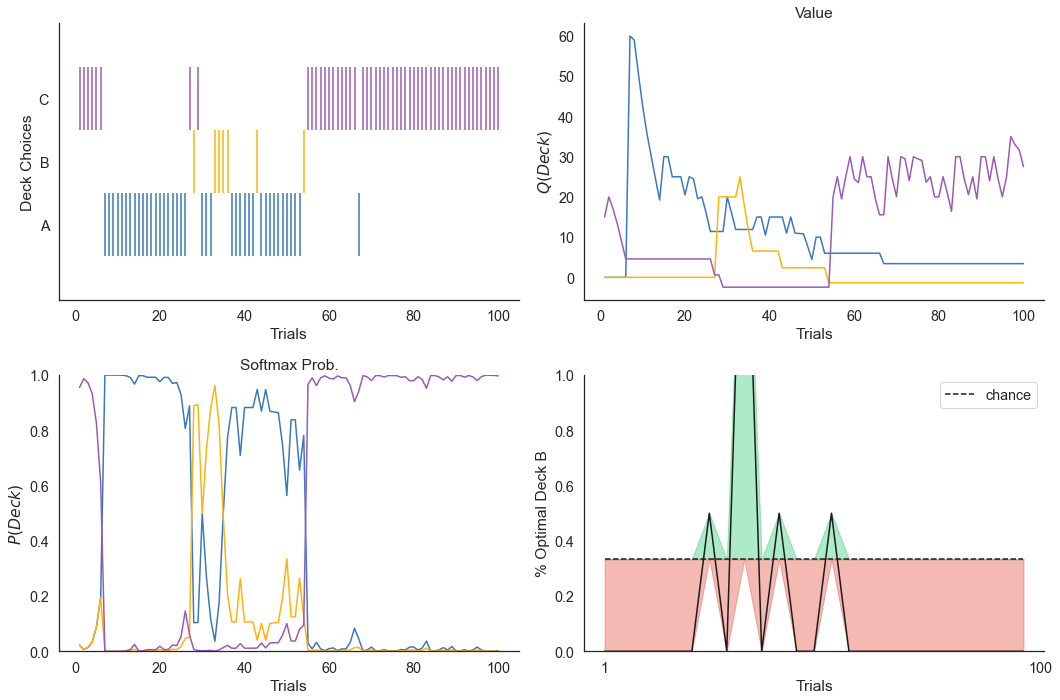

In [24]:
#agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, gamma=gamma)
agent = Qagent(alpha_g=1, alpha_l=0.1, beta=0.25, gamma=1)

# play 800 trials of multi-armed bandit task
data = agent.play_tmpTask(ntrials=100, get_output=True)

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data)

In [20]:
def agent_df(agmax, almax, astep, given_beta, given_gamma):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Gamma', 'probA', 'probB', 'probC'])
    df = pd.DataFrame(dtype=float, columns=df_columns)
    
    for cycle in np.arange(0, 100, 1): #changed stop from 50**
        
        #alpha gains should only be positive, 0 to 1 for example
        for alpha_g in np.arange(0, agmax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for alpha_l in np.arange(0, almax, astep):

                beta = given_beta
                gamma = given_gamma
                alpha_g, alpha_l, beta = np.round(alpha_g, 3), np.round(alpha_l, 3), np.round(beta, 3)
                agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, gamma=gamma)
                data = agent.play_tmpTask(ntrials=100, get_output=True)
                scores = get_tmpTask_scores(data)
                #print(scores)
                
                probA, probB, probC = scores.iloc[0], scores.iloc[1], scores.iloc[2]
                trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, gamma, probA, probB, probC]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    return df

#### Q-Agent Perfomance Parameter Analysis for the following ranges:
* $\beta$ = 0.003 - 0.006
* $\alpha_{Gains}$ = 0 - 2
* $\alpha_{Loss}$ = 0 - 2
* $\gamma$ = 0.5, 1, 2

In [13]:
# agent_df(agmax, almax, astep, given_beta, given_gamma)
#mydf1 = agent_df(2, 2, .1, .003, 0.5)
#mydf2 = agent_df(2, 2, .1, .003, 1)
#mydf3 = agent_df(2, 2, .1, .003, 1)
#mydf4 = agent_df(2, 2, .1, .006, 0.5)
mydf5 = agent_df(1, 1, .05, .5, 1) #before: 2, 2, .1, .5, 1
#mydf6 = agent_df(2, 2, .1, .006, 2)

In [14]:
#mydf5

In [15]:
# Saving Q-Agent data for Parameter analysis in a List of Q-Agent Dataframes
mydfs_dup = [mydf5]     #[mydf1, mydf2, mydf3, mydf4, mydf5, mydf6]
mydfs = []

for df in mydfs_dup:
    df = df.groupby(['Alpha Gain', 'Alpha Loss'])[['Beta', 'Gamma','probA', 'probB', 'probC']].mean().reset_index()
    mydfs.append(df)

## Heat Maps
### Defines Heat Maps of Payoff Scores for $\alpha_{Gains}$ and $\alpha_{Loss}$ with Parameter Analysis Q-Agents
* $\beta$ = 0.003 - 0.006
* $\alpha_{Gains}$ = 0 - 2
* $\alpha_{Loss}$ = 0 - 2
* $\gamma$ = 0.5, 1, 2

<ipython-input-16-b266d04e59e7>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


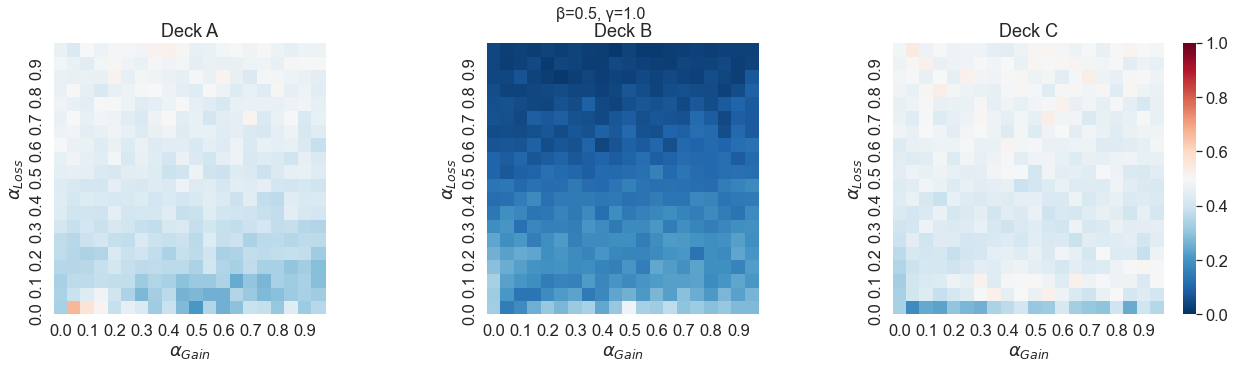

In [16]:
sns.set_theme()
sns.set_context("notebook", font_scale=1.5)

grid_kws = {"hspace": 0, "wspace": 0.2}
fig, axs = plt.subplots(1,3, figsize=(22,5), gridspec_kw=grid_kws)
axs = axs.ravel()

for i in range(len(mydfs)):   
    df = mydfs[i]
    curr_ax = axs[i]

    
    heatmap_dfA = pd.pivot(df, index = "Alpha Loss", columns = "Alpha Gain", values = "probA").astype('float')
    heatmap_dfB = pd.pivot(df, index = "Alpha Loss", columns = "Alpha Gain", values = "probB").astype('float')
    heatmap_dfC = pd.pivot(df, index = "Alpha Loss", columns = "Alpha Gain", values = "probC").astype('float')
    sns.heatmap(heatmap_dfA, square = True, cmap='RdBu_r', vmin=0, vmax=1, xticklabels=2, cbar=False, 
                ax= axs[0]).invert_yaxis()
    sns.heatmap(heatmap_dfB, square = True, cmap='RdBu_r', vmin=0, vmax=1, xticklabels=2, cbar=False, 
              ax= axs[1]).invert_yaxis()
    sns.heatmap(heatmap_dfC, square = True, cmap='RdBu_r', vmin=0, vmax=1, xticklabels=2, cbar=True, 
               ax= axs[2]).invert_yaxis()
    beta = round(df["Beta"][0], 3)
    gamma = round(df["Gamma"][0], 3)
    fig.suptitle(f"\u03B2={beta}, \u03B3={gamma} \n", fontsize = 16)
    #axs[0].set_title(f"\u03B2={beta}, \u03B3={gamma} \n")
    axs[0].set(ylabel='$\u03B1_{Loss}$')
    axs[0].set(xlabel='$\u03B1_{Gain}$')
    axs[0].set_title("Deck A")
    
    axs[1].set(ylabel='$\u03B1_{Loss}$')
    axs[1].set(xlabel='$\u03B1_{Gain}$')
    axs[1].set_title("Deck B")
    
    
    axs[2].set(ylabel='$\u03B1_{Loss}$')
    axs[2].set(xlabel='$\u03B1_{Gain}$')
    axs[2].set_title("Deck C")
    fig.savefig('QAgentHeatMaps.png', bbox_inches='tight')
   
    plt.tight_layout()

In [17]:
def ratioDeck_calc(deck):
    sumDeck = np.sum(deck, axis=1)
    below_threshold_sum = sumDeck.iloc[1:3].sum()
    above_threshold_sum = sumDeck.iloc[3:].sum()
    ratioDeck = (below_threshold_sum) / (above_threshold_sum)
    return ratioDeck

print(ratioDeck_calc(heatmap_dfA))
print(ratioDeck_calc(heatmap_dfB))
print(ratioDeck_calc(heatmap_dfC))

0.08994512056124691
0.23054858180652754
0.11664304833884429


In [18]:
#scale = range(1, 11, 1)
#base = range(5, 36, 5)
lst = []

deck_df = pd.DataFrame(lst, index = ["scale"], columns = ["base"])

for scale in range(1, 11, 1):
    for base in range(5, 36, 5):
        deckA = buildDecks(25, 5, 2000, 5, 1.1, -40, 5)
        deckA(scale, base)#run agent here
        ratioDeckA = ratioDeck_calc(heatmap_dfA)
deck_df.append(ratioDeckA)
        
#print(deckA(scale))
#print(deck_df)

TypeError: 'tuple' object is not callable